# 1.2 Construção do Modelo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from utilities.show_results import plot_confusion_matrix, get_accuracy, get_precision, f_score
from utilities.pearson_correlation import choose_with_pearson
from utilities.neuron_architectures import create_architectures, test_alphas

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from joblib import load, dump

## 1.2.1 Abrindo o dataset e tratando os dados

In [2]:
data = pd.read_csv('PCOS.csv')

In [3]:
data.head(2)

,Unnamed: 0,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0,0,28,44.6,152.0,19.3,15,78,22,10.48,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,1,0,36,65.0,161.5,24.9,15,74,20,11.70,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              538 non-null    int64  
 1   PCOS (Y/N)              538 non-null    int64  
 2    Age (yrs)              538 non-null    int64  
 3   Weight (Kg)             538 non-null    float64
 4   Height(Cm)              538 non-null    float64
 5   BMI                     538 non-null    float64
 6   Blood Group             538 non-null    int64  
 7   Pulse rate(bpm)         538 non-null    int64  
 8   RR (breaths/min)        538 non-null    int64  
 9   Hb(g/dl)                538 non-null    float64
 10  Cycle(R/I)              538 non-null    int64  
 11  Cycle length(days)      538 non-null    int64  
 12  Marraige Status (Yrs)   538 non-null    float64
 13  Pregnant(Y/N)           538 non-null    int64  
 14  No. of abortions        538 non-null    in

## Usando a correlação de Pearson para encontrar os melhores atributos preditores

In [5]:
X = data.drop(columns=['PCOS (Y/N)'], axis=1)
y = data["PCOS (Y/N)"]

In [6]:
X_selected, _ = choose_with_pearson(20, X, y)

In [7]:
correlation = data.corr()
correlation["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.650929
Follicle No. (L)          0.601208
Skin darkening (Y/N)      0.481323
hair growth(Y/N)          0.466508
Weight gain(Y/N)          0.443093
Cycle(R/I)                0.401837
Fast food (Y/N)           0.380985
Pimples(Y/N)              0.290335
AMH(ng/mL)                0.263974
Weight (Kg)               0.209969
BMI                       0.198854
Hair loss(Y/N)            0.176496
Waist(inch)               0.161922
Hip(inch)                 0.160882
Avg. F size (L) (mm)      0.129997
Endometrium (mm)          0.107639
Avg. F size (R) (mm)      0.094528
Pulse rate(bpm)           0.092699
Hb(g/dl)                  0.087809
Vit D3 (ng/mL)            0.085825
Reg.Exercise(Y/N)         0.071979
Height(Cm)                0.065465
LH(mIU/mL)                0.064074
Unnamed: 0                0.057574
RBS(mg/dl)                0.049452
RR (breaths/min)          0.038641
Blood Group               0.033701
BP _Diastolic (mmHg)

In [8]:
selected_df = pd.merge(X_selected, data['PCOS (Y/N)'], left_index=True, right_index=True)
selected_df.to_csv("data/PCOS_selected_pearson.csv", index=False)

## Separando o conjunto de testes e treino

Partição 70/30

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30)

X_train.shape, X_test.shape, (y_test == 1).sum(), (y_test == 0).sum()

((376, 42), (162, 42), 43, 119)

### Normalizando os atributos preditores

In [10]:
X_train_norm = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))

X_test_norm = (X_test - np.min(X_train))/(np.max(X_train) - np.min(X_train))

C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


## Resultados da busca em grade

### Carregando o melhor modelo da busca em grade com todos os parâmetros

In [11]:
clf_45 = load('models/pcos-diagnosis-45-params.joblib')

ACURÁCIA: 0.8996
F-SCORE: 0.8996


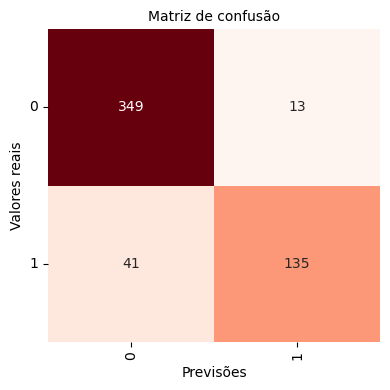

In [12]:
y_pred = clf_45.predict(X.values)

get_accuracy(y, y_pred)
f_score(y, y_pred)
plot_confusion_matrix(y, y_pred)

### Carregando o melhor modelo da busca em grade com 20 parâmetros escolhidos a partir da correlação de Pearson

In [13]:
clf_20_pearson = load('models/pcos-diagnosis-20-params.joblib')

ACURÁCIA: 0.9238
F-SCORE: 0.9238


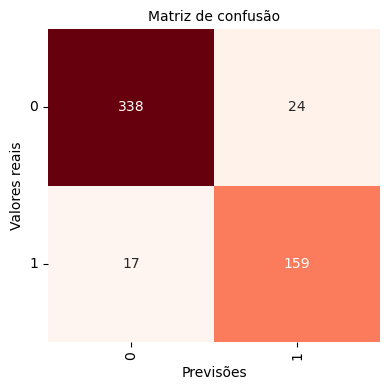

In [14]:
y_pred = clf_20_pearson.predict(X[X_selected.columns].values)

get_accuracy(y, y_pred)
f_score(y, y_pred)
plot_confusion_matrix(y, y_pred)

### Carregando o melhor modelo da busca em grade com 20 parâmetros escolhidos com SelectK

In [15]:
clf_20_selectk = load('models/pcos-diagnosis-20-params-selectk.joblib')

In [16]:
df = pd.read_csv("data/PCOS_selected_features.csv")
X_2 = df.drop(columns=["PCOS (Y/N)"], axis=1)
y_2 = df["PCOS (Y/N)"]

ACURÁCIA: 0.5929
F-SCORE: 0.5929


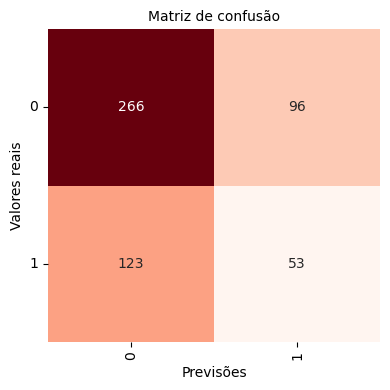

In [17]:
y_pred = clf_20_selectk.predict(X_2.values)

get_accuracy(y_2, y_pred)
f_score(y_2, y_pred)
plot_confusion_matrix(y_2, y_pred)

## Algoritmo XGBoost

In [18]:
clf = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=120,
    random_state=0).fit(X_train_norm, y_train)

print(clf.score(X_test_norm, y_test))

print("=-=-=-=-=-=-=")

errors = [mean_squared_error(y_test, y_pred)
          for y_pred in clf.staged_predict(X_test_norm)]

best_n_estimator = np.argmin(errors) + 1

clf_best =  GradientBoostingClassifier(
    max_depth=2,
    n_estimators=best_n_estimator,
    random_state=0).fit(X_train_norm, y_train)

print(clf_best.score(X_test_norm, y_test))

y_pred = clf.predict(X_test_norm)

0.9074074074074074
=-=-=-=-=-=-=
0.9135802469135802


ACURÁCIA: 0.9074
F-SCORE: 0.9074


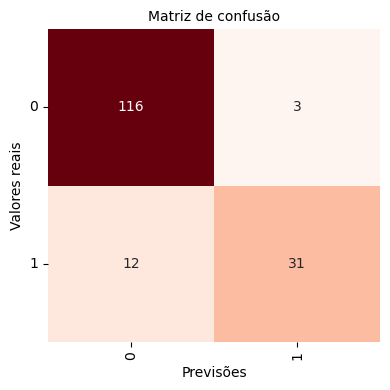

In [19]:
get_accuracy(y_test, y_pred)
f_score(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

### Utilizando a biblioteca xgboost para prever somente com 20 atributos preditores selecionados a partir da correlação de Pearson

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y,test_size=0.30)

X_train_norm = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))
X_test_norm = (X_test - np.min(X_train))/(np.max(X_train) - np.min(X_train))

C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [21]:
clf_xgb = xgb.XGBClassifier()

In [22]:
xgb_results = cross_val_score(clf_xgb, X_train_norm.values, y_train, cv=5)
xgb_results.mean()

0.880421052631579

In [23]:
clf_xgb_modified = xgb.XGBClassifier(max_depth=2)
cross_val_score(clf_xgb_modified, X_train_norm.values, y_train).mean()

0.8777894736842106

In [24]:
class_xgb = xgb.XGBClassifier(booster='gblinear')
cross_val_score(class_xgb, X_train_norm.values, y_train).mean()

0.9070526315789473

In [25]:
class_xgb.fit(X_train_norm.values, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
y_xgb_pred = class_xgb.predict(X_test_norm)

ACURÁCIA: 0.9012


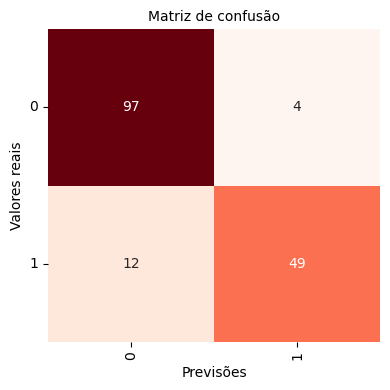

In [27]:
get_accuracy(y_test, y_xgb_pred)
plot_confusion_matrix(y_test, y_xgb_pred)

In [28]:
(y_test == 1).sum(), (y_test == 0).sum(), len(y_test)

(61, 101, 162)

### Salvando modelo XGBoost

In [29]:
dump(class_xgb, 'models/pcos-diagnosis-20-params-xgb.joblib')

['models/pcos-diagnosis-20-params-xgb.joblib']

## Validação Cruzada

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
scores_mlp_pearson = cross_val_score(clf_20_pearson, X_selected.values, y, cv=kf, scoring='accuracy')
scores_mlp = cross_val_score(clf_45, X.values, y, cv=kf, scoring='accuracy')

In [31]:
print("Acurácia XGBoost: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(f"Acurácia MLPClassifier com 20 parâmetros: {scores_mlp_pearson.mean():.4f} (+/- {scores_mlp_pearson.std() * 2:.2f})")
print(f"Acurácia MLPClassifier com 45 parâmetros: {scores_mlp.mean():.4f} (+/- {scores_mlp.std() * 2:.2f})")

Acurácia XGBoost: 0.8960 (+/- 0.08)
Acurácia MLPClassifier com 20 parâmetros: 0.8680 (+/- 0.11)
Acurácia MLPClassifier com 45 parâmetros: 0.6746 (+/- 0.14)
